In [1]:
import pandas as pd
import db_utils as db

In [2]:
# Loading loan_payments.csv

credentials = db.load_credentials()
connector = db.RDSDatabaseConnector(credentials)
connector.init_engine()
loan_payments = connector.extract_loan_payments_data()

db.save_df_as_csv(loan_payments, 'loan_payments.csv')

File saved.


In [3]:
# Investigate 'loan_payments' and found which columns need their datatypes changing

print(loan_payments.info())
print(loan_payments.head())
print(loan_payments.iloc[:, 10:34])
cols_dtype_to_timedelta = ['term', 'employment_length']
cols_dtype_to_datetime = ['issue_date', 'earliest_credit_line']
cols_dtype_to_float = ['loan_amount']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

In [4]:
# We need to change a few values first. Making these adjustments before changing the datatype so that we can 
# change employment_length to numeric value

value_changes = {'10+ years': '10 years', '< 1 year': '1 year'}
loan_payments[cols_dtype_to_timedelta] = loan_payments[cols_dtype_to_timedelta].replace(to_replace=value_changes)
print(loan_payments[cols_dtype_to_timedelta].value_counts())


term       employment_length
36 months  10 years             9760
           1 year               6161
60 months  10 years             4821
36 months  2 years              3530
           3 years              3129
           5 years              2564
           4 years              2350
           6 years              2012
           7 years              1896
60 months  1 year               1762
36 months  8 years              1670
           9 years              1251
60 months  2 years              1084
           3 years              1059
           5 years               948
           4 years               814
           7 years               806
           6 years               788
           8 years               647
           9 years               488
Name: count, dtype: int64


In [5]:
# Initialising instance of DataTransform, then using method to return converted columns and directly assigning 
# them to the columns whose data they are transforming

transformer_1 = db.DataTransform()

loan_payments[cols_dtype_to_timedelta] = transformer_1.convert_col_to_months(loan_payments, cols_dtype_to_timedelta)

loan_payments[cols_dtype_to_datetime] = transformer_1.convert_col_to_datetime(loan_payments, cols_dtype_to_datetime)

loan_payments[cols_dtype_to_float] = transformer_1.convert_col_to_float(loan_payments, cols_dtype_to_float)



In [6]:
# Having a look at the columns with nulls

info_1 = db.DataFrameInfo()

null_cols = info_1.col_null_percentages(loan_payments)

null_cols = null_cols[null_cols > 0]

print(null_cols)

loan_payments[null_cols.index]


funded_amount                  0.055448
int_rate                       0.095314
mths_since_last_delinq         0.571666
mths_since_last_record         0.886025
last_payment_date              0.001346
next_payment_date              0.601280
last_credit_pull_date          0.000129
collections_12_mths_ex_med     0.000940
mths_since_last_major_derog    0.861721
dtype: float64


,funded_amount,int_rate,mths_since_last_delinq,mths_since_last_record,last_payment_date,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog
0,8000.0,7.49,5.0,NaN,Jan-2022,Feb-2022,Jan-2022,0.0,5.0
1,13200.0,6.99,NaN,NaN,Jan-2022,Feb-2022,Jan-2022,0.0,NaN
2,16000.0,7.49,69.0,NaN,Oct-2021,None,Oct-2021,0.0,NaN
3,15000.0,14.31,74.0,NaN,Jun-2021,None,Jun-2021,0.0,NaN
4,15000.0,6.03,37.0,NaN,Jan-2022,Feb-2022,Jan-2022,0.0,NaN
...,...,...,...,...,...,...,...,...,...
54226,5000.0,9.01,5.0,NaN,Jul-2016,None,Jul-2016,NaN,NaN
54227,5000.0,10.59,0.0,0.0,Oct-2016,None,Sep-2016,0.0,NaN
54228,3500.0,7.43,NaN,NaN,Sep-2016,Sep-2016,May-2013,NaN,NaN
54229,5000.0,7.43,0.0,0.0,Mar-2014,None,May-2013,NaN,NaN


In [7]:
# First thing to see is we should drop three columns: mths_since_last_delinq, mths_since_last_record 
# and mths_since_last_major_derog

loan_payments= loan_payments.drop(['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog'], axis=1)

In [8]:
# Missed one, let's drop next_payment_date too

loan_payments = loan_payments.drop('next_payment_date',axis=1)

In [9]:
# Let's get the updated list of columns with nulls back, it should be 4 shorter

null_cols = info_1.col_null_percentages(loan_payments)

null_cols = null_cols[null_cols > 0]

print(null_cols)

# We now we need to test for whether these are missing (completely) at random or not. To do this we need to check 
# for correlation between whether a value is missing and other variables in the loan_payments data frame. We can begin 
# this by creating Boolean variables for whether rows miss these null-column values. This is what the df cols_corr is

cols_corr = {}
for col in null_cols.index:
    cols_corr[f'{col}_missing'] = loan_payments[col].isnull()

cols_corr = pd.DataFrame(cols_corr)

cols_corr


funded_amount                 0.055448
int_rate                      0.095314
last_payment_date             0.001346
last_credit_pull_date         0.000129
collections_12_mths_ex_med    0.000940
dtype: float64


,funded_amount_missing,int_rate_missing,last_payment_date_missing,last_credit_pull_date_missing,collections_12_mths_ex_med_missing
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
54226,False,False,False,False,True
54227,False,False,False,False,False
54228,False,False,False,False,True
54229,False,False,False,False,True


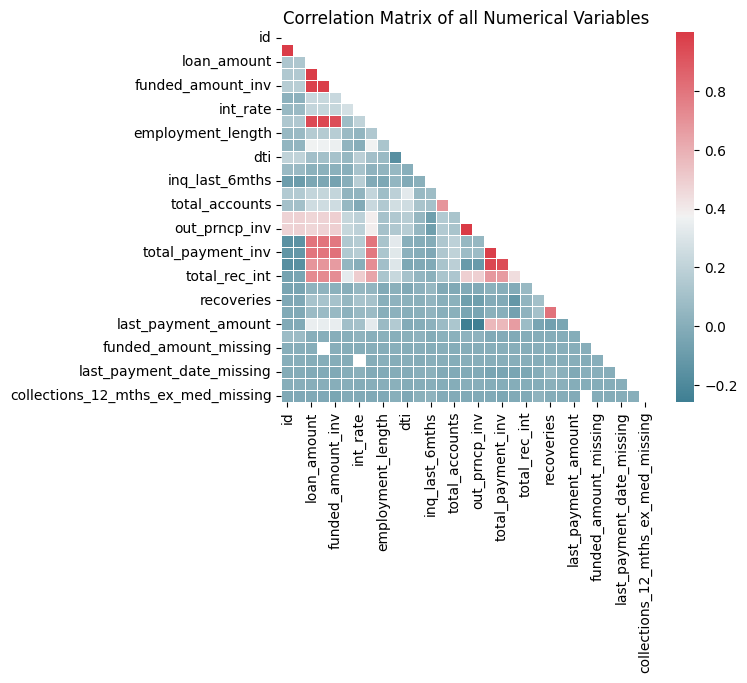

In [10]:
# Now we need to check whether there are correlations between these columns and any other columns of the loan_payments df
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr_df = pd.concat([loan_payments.select_dtypes(include='number'), cols_corr], axis=1).drop(['policy_code'], axis=1)

corr = corr_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# set thins up for plotting
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap

sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

In [11]:
# We can see from the section at the bottom where our missing variables are that the nulls appear to be missing 
# (completely) at random. Therefore, can impute with median, mean or mode. In order to decide on one let's plot 
# the variables themselves

numeric_null_cols = loan_payments[null_cols.index].select_dtypes(include='number').columns.to_list()

info_1.col_stats(loan_payments, numeric_null_cols)

,funded_amount,int_rate,collections_12_mths_ex_med
median,12000.000000,13.160000,0.000000
mean,13229.509117,13.507328,0.004208
std,8019.017599,4.392893,0.070990


In [12]:
# All three can be imputed with the median 

df_transformer_1 = db.DataFrameTransformer()

for col in numeric_null_cols:
    df_transformer_1.impute_col_with_median(loan_payments, col)


In [13]:
# So what have we got left? # Let's get the updated list of columns with nulls back, it should be 3 shorter

null_cols = info_1.col_null_percentages(loan_payments)
null_cols


id                            0.000000
member_id                     0.000000
loan_amount                   0.000000
funded_amount                 0.000000
funded_amount_inv             0.000000
term                          0.000000
int_rate                      0.000000
instalment                    0.000000
grade                         0.000000
sub_grade                     0.000000
employment_length             0.000000
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_date                    0.000000
loan_status                   0.000000
payment_plan                  0.000000
purpose                       0.000000
dti                           0.000000
delinq_2yrs                   0.000000
earliest_credit_line          0.000000
inq_last_6mths                0.000000
open_accounts                 0.000000
total_accounts                0.000000
out_prncp                     0.000000
out_prncp_inv            

In [14]:
# These null percentages are low and it is awkward to impute categorical data like dates, so we can drop these rows

loan_payments=loan_payments.dropna(axis=0, subset=null_cols.index.to_list())

# We will now see that there are no nulls left

null_cols = info_1.col_null_percentages(loan_payments)
null_cols

id                            0.0
member_id                     0.0
loan_amount                   0.0
funded_amount                 0.0
funded_amount_inv             0.0
term                          0.0
int_rate                      0.0
instalment                    0.0
grade                         0.0
sub_grade                     0.0
employment_length             0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
issue_date                    0.0
loan_status                   0.0
payment_plan                  0.0
purpose                       0.0
dti                           0.0
delinq_2yrs                   0.0
earliest_credit_line          0.0
inq_last_6mths                0.0
open_accounts                 0.0
total_accounts                0.0
out_prncp                     0.0
out_prncp_inv                 0.0
total_payment                 0.0
total_payment_inv             0.0
total_rec_prncp               0.0
total_rec_int 

In [15]:
# Its time to save the latest version of loan_payments locally now the nulls have been removed or imputed

db.save_df_as_csv(loan_payments, 'loan_payments.csv')

File saved.


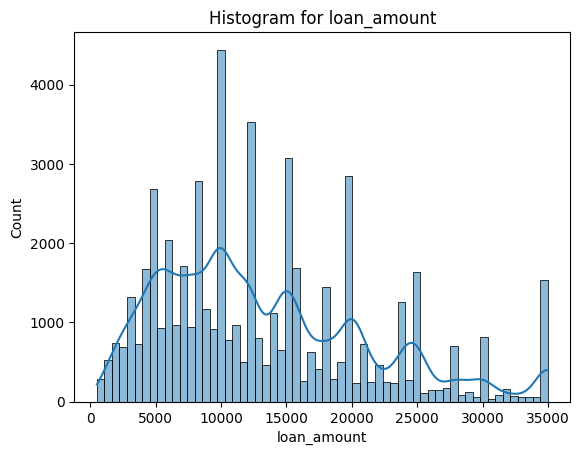

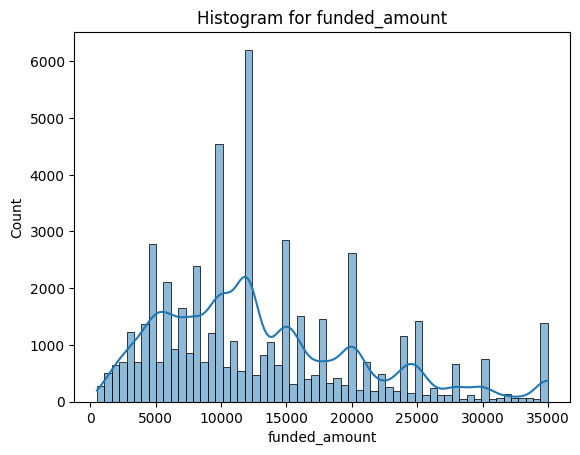

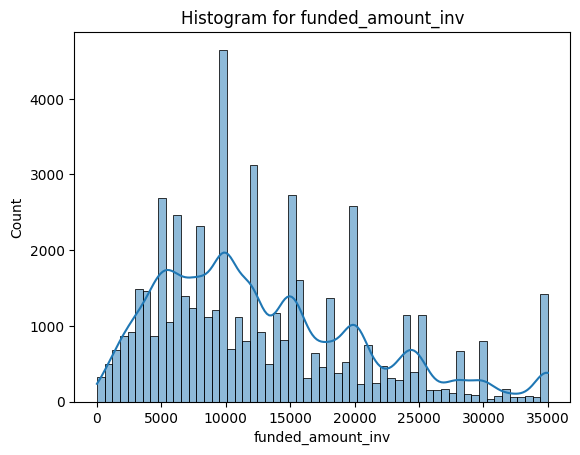

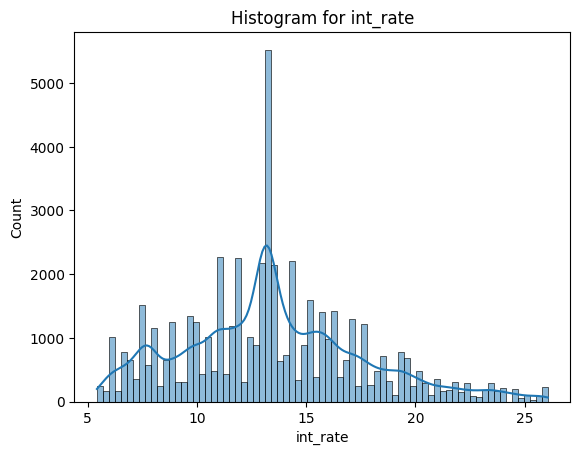

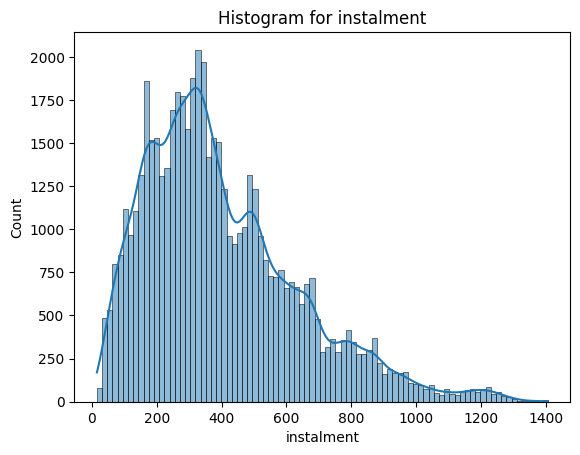

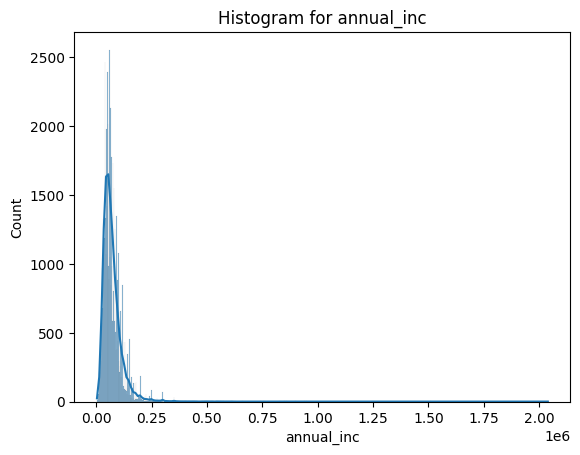

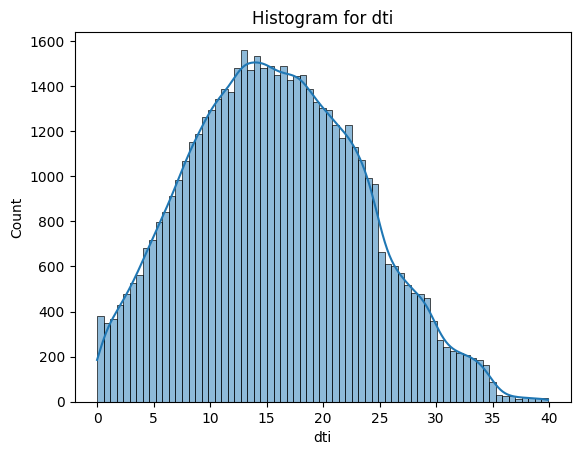

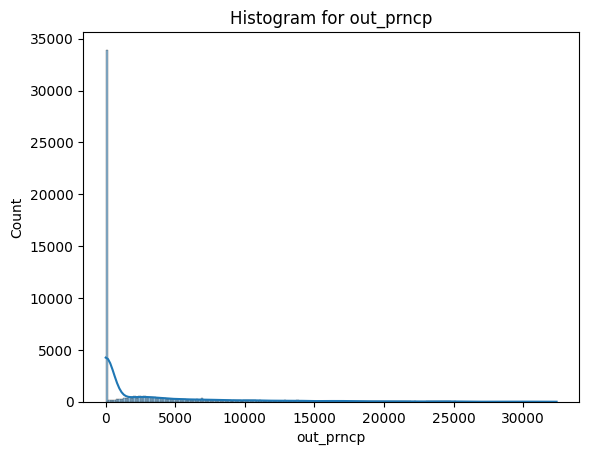

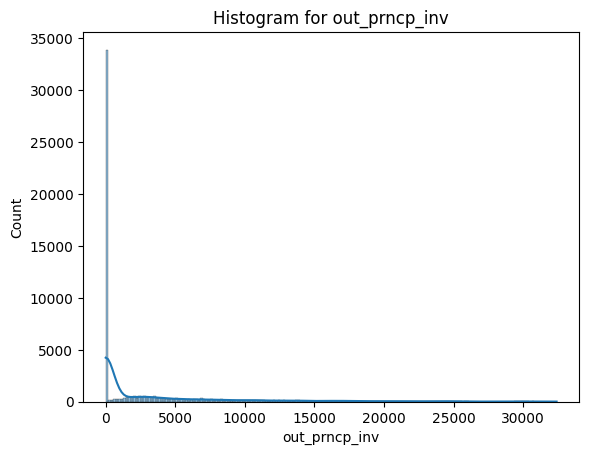

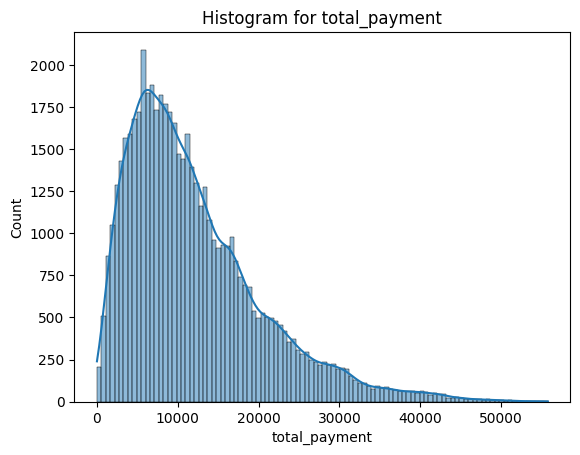

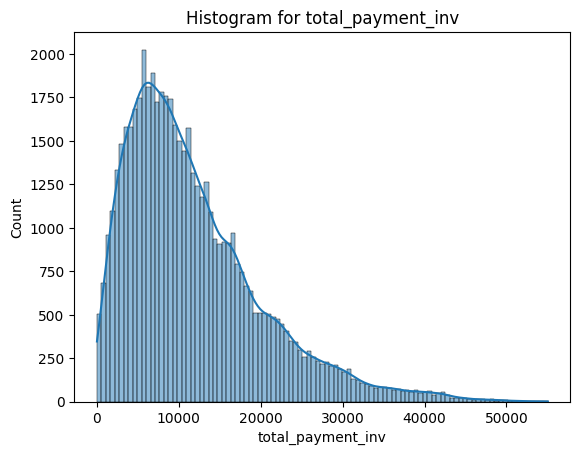

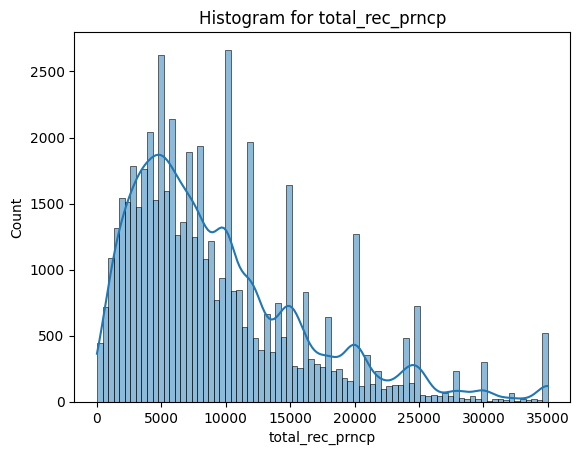

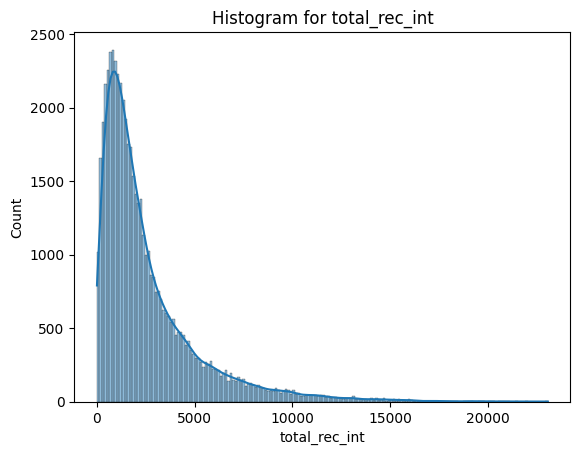

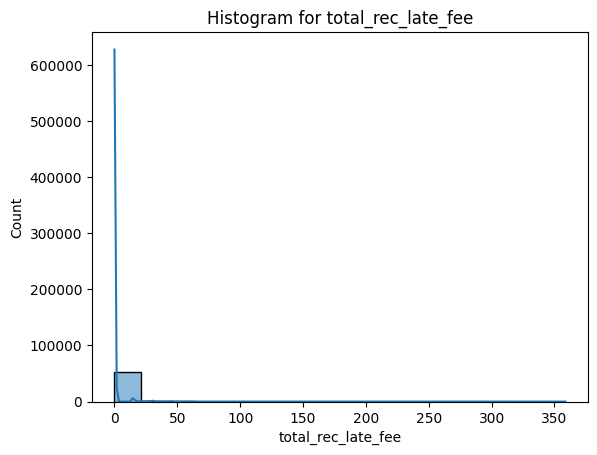

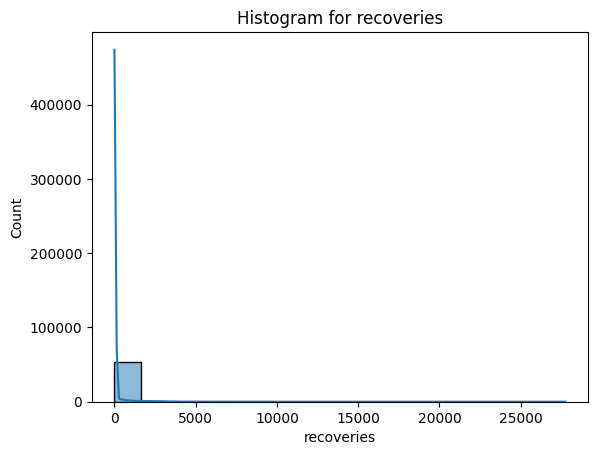

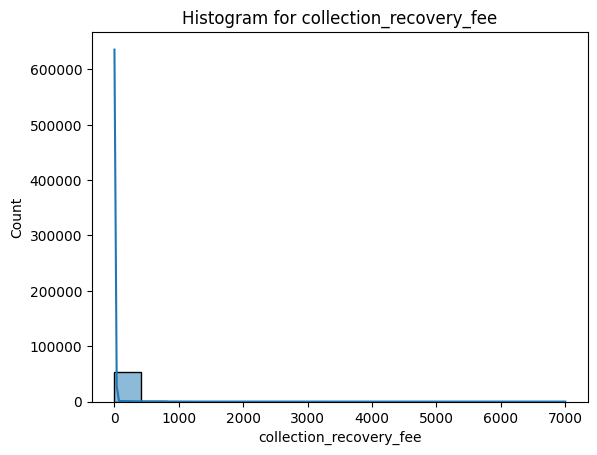

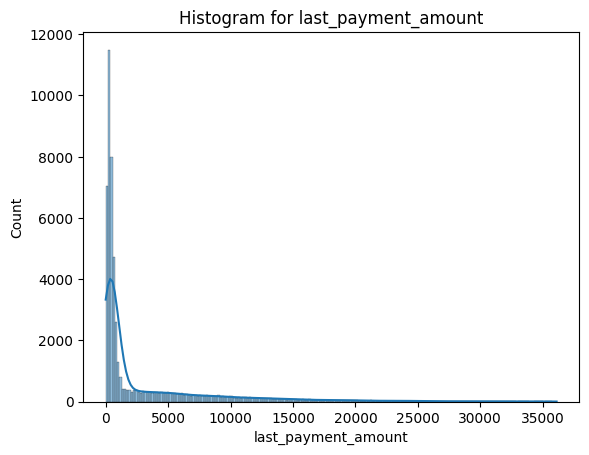

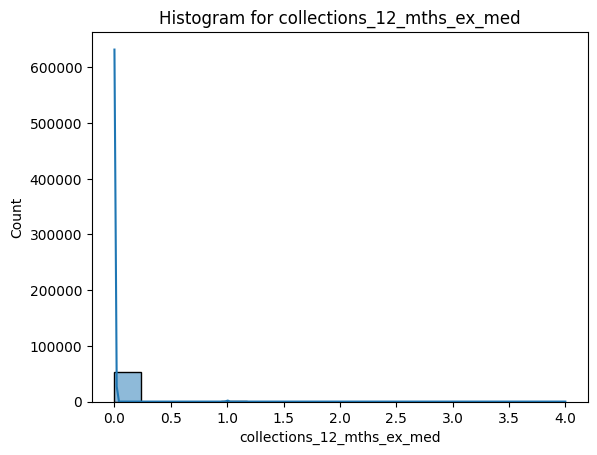

In [16]:
# Let's first visualise all our numeric columns

plotter_1 = db.Plotter()

floats_df = loan_payments.select_dtypes(include='float')

plotter_1.kde_plot(floats_df, floats_df.columns.to_list())

In [17]:
# From these plots we can begin to draw up a list of those that visually appear skewed, and check whether numerically 
# they are in fact skewed. I will create a function that checks for the skew of a column, and if the absolute value of 
# the skew is greater than 1, then we add it to the list of skewed columns

skewed_cols = []

for c in loan_payments.select_dtypes(include='float').columns.to_list():
    print(f'Col: {c} has skew {info_1.col_skewness(loan_payments, col=c)}')
    if abs(info_1.col_skewness(loan_payments, col=c)) > 1:
        skewed_cols.append(c)
    
skewed_cols


Col: loan_amount has skew 0.8049220181025606
Col: funded_amount has skew 0.8696343258205478
Col: funded_amount_inv has skew 0.8133760847946324
Col: int_rate has skew 0.45661978102982004
Col: instalment has skew 0.9965721690437305
Col: annual_inc has skew 8.717499605870014
Col: dti has skew 0.18910057534680505
Col: out_prncp has skew 2.35405079479137
Col: out_prncp_inv has skew 2.354471408893565
Col: total_payment has skew 1.2698752968451772
Col: total_payment_inv has skew 1.257870048149293
Col: total_rec_prncp has skew 1.2626785390807123
Col: total_rec_int has skew 2.2045848938701638
Col: total_rec_late_fee has skew 13.174553220535644
Col: recoveries has skew 14.389298686317593
Col: collection_recovery_fee has skew 27.807754340152847
Col: last_payment_amount has skew 2.4972203995928135
Col: collections_12_mths_ex_med has skew 20.307695011511576


['annual_inc',
 'out_prncp',
 'out_prncp_inv',
 'total_payment',
 'total_payment_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_payment_amount',
 'collections_12_mths_ex_med']

annual_inc


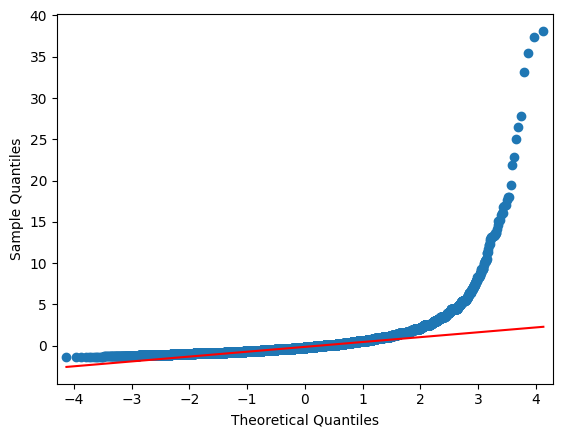

out_prncp


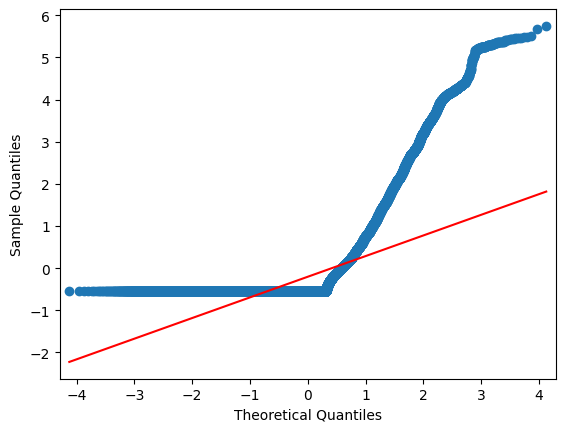

out_prncp_inv


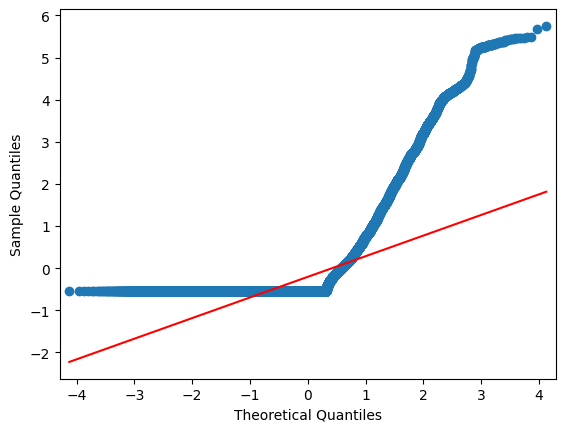

total_payment


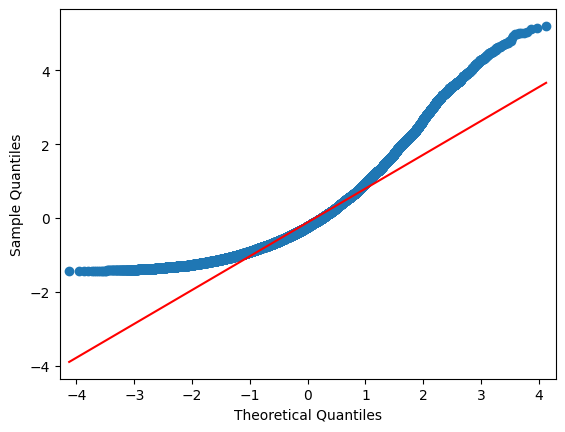

total_payment_inv


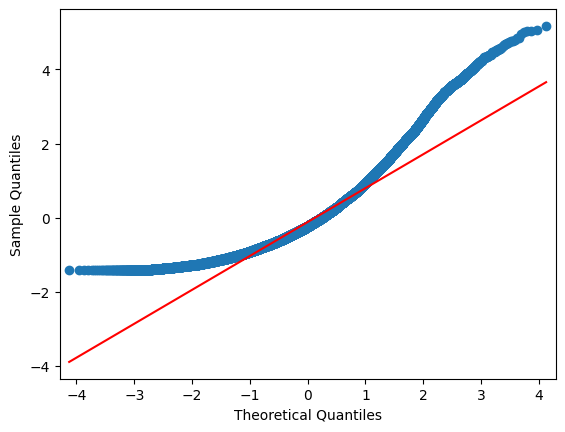

total_rec_prncp


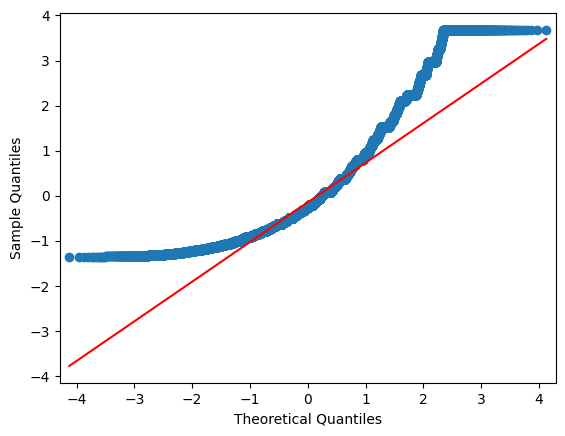

total_rec_int


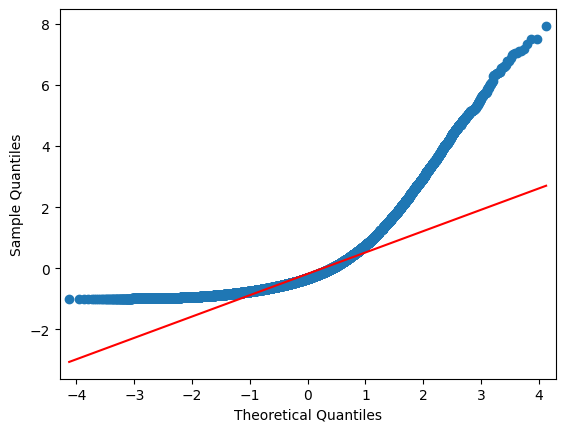

total_rec_late_fee


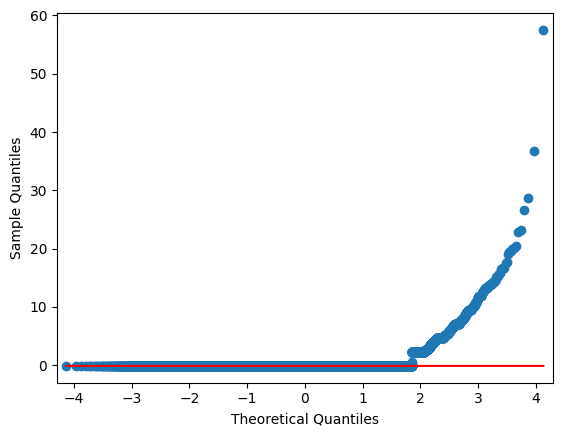

recoveries


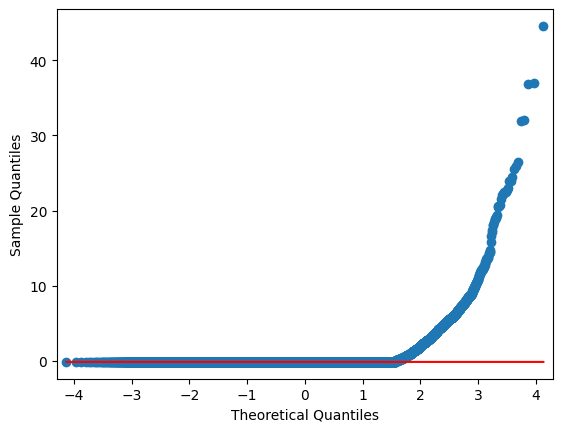

collection_recovery_fee


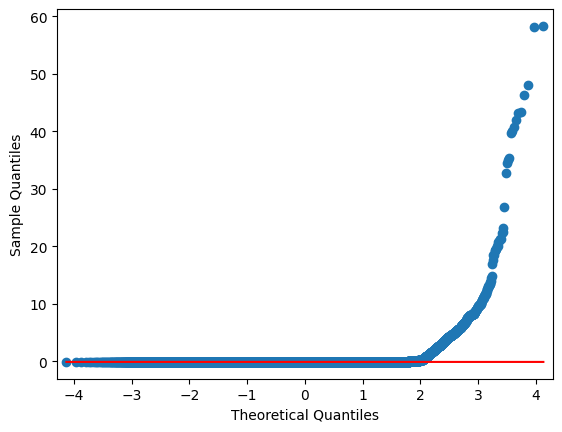

last_payment_amount


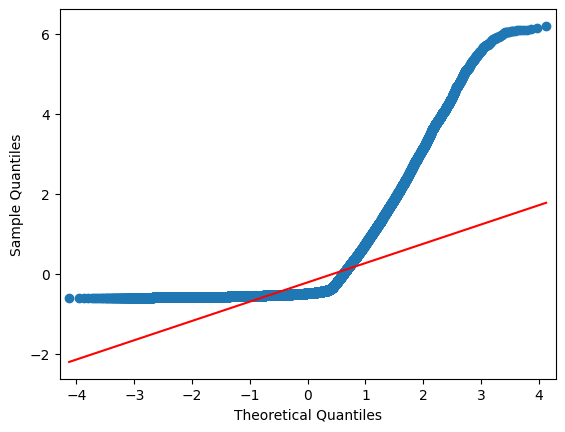

collections_12_mths_ex_med


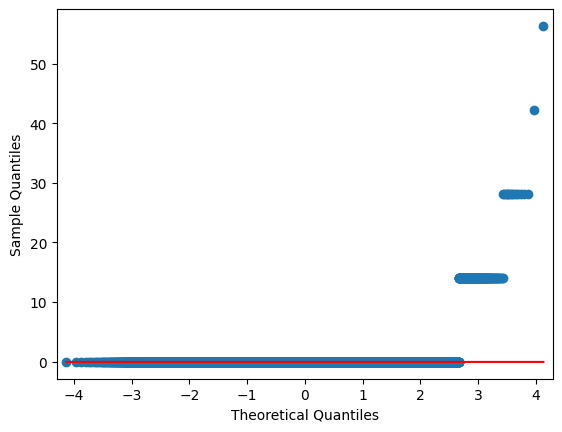

In [18]:
# Now let's look at the remaining numerically skewed columns with QQ plots

for col in skewed_cols:
    print(col)
    plotter_1.QQ_plot(loan_payments, col)

In [19]:
# None of these have negative values, and all have positive skwes. Therefore, a simple log transformation is acceptable 
# for each. The final column, 'collections_12_months_ex_med' clearly shouldn't be a float column, though, as we can see 
# it is not a continuous variable. Therefore, we will first drop this and then perform log transformations. 

skewed_cols.remove('collections_12_mths_ex_med')

for col in skewed_cols:
    df_transformer_1.log_transform(loan_payments, col)

Skew of annual_inc after log transformation: 0.1392027966594716
Skew of out_prncp after log transformation: 0.5747920784811102
Skew of out_prncp_inv after log transformation: 0.5748660863876571
Skew of total_payment after log transformation: -0.753245742366305
Skew of total_payment_inv after log transformation: -2.7583440513798707
Skew of total_rec_prncp after log transformation: -0.9154651953778844
Skew of total_rec_int after log transformation: -0.5625331810602692
Skew of total_rec_late_fee after log transformation: 5.505069277708757
Skew of recoveries after log transformation: 3.8204335813518835
Skew of collection_recovery_fee after log transformation: 5.41486519744669
Skew of last_payment_amount after log transformation: 0.12803761707038572


In [28]:
# We can see that the log transformation works for all columns but three: total_rec_late_fee, recoveries and 
# collection_recovery_fee. Let's get some more info on these columns:

three_cols = ['total_rec_late_fee', 'recoveries', 'collection_recovery_fee']

# Let's check for outliers

plotter_1.box_whiskers_plot(loan_payments, three_cols)

# Let's see what a Yeo-Johnson transformation does

for col in three_cols:
    df_transformer_1.yeo_johnson_transform(loan_payments, col)

# There aren't any obvious outliers, nor does a Y-J transformation work. We have to accept that this data is going to be
# difficult to transform to a normal distribution. Therefore, we should leave them alone. We can remove them from our skewed
# columns to be log-transformed, and then log transform the rest:

for col in three_cols:
    skewed_cols.remove(col)

for col in skewed_cols:
    loan_payments[col]= df_transformer_1.log_transform(loan_payments, col)




Skew of total_rec_late_fee after Yeo-Johnson transformation: 5.274700695736178
Skew of recoveries after Yeo-Johnson transformation: 3.4749152335612794
Skew of collection_recovery_fee after Yeo-Johnson transformation: 3.618299035083886
Skew of annual_inc after log transformation: 0.1392027966594716
Skew of out_prncp after log transformation: 0.5747920784811102
Skew of out_prncp_inv after log transformation: 0.5748660863876571
Skew of total_payment after log transformation: -0.753245742366305
Skew of total_payment_inv after log transformation: -2.7583440513798707
Skew of total_rec_prncp after log transformation: -0.9154651953778844
Skew of total_rec_int after log transformation: -0.5625331810602692
Skew of last_payment_amount after log transformation: 0.12803761707038572


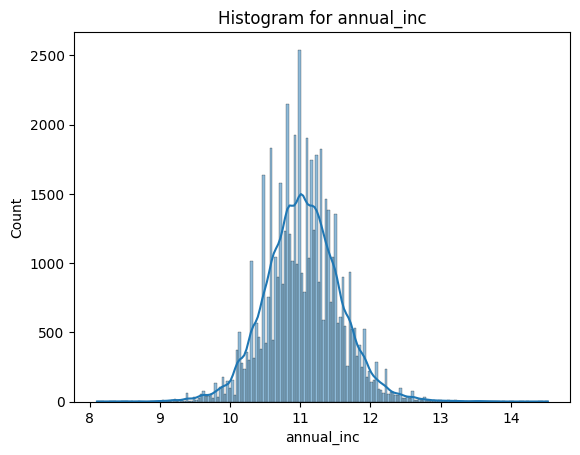

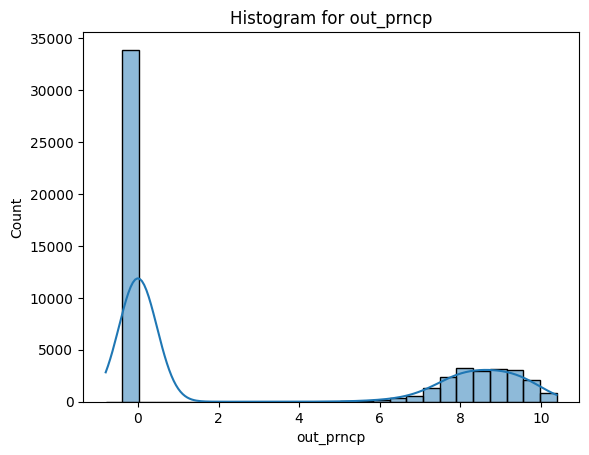

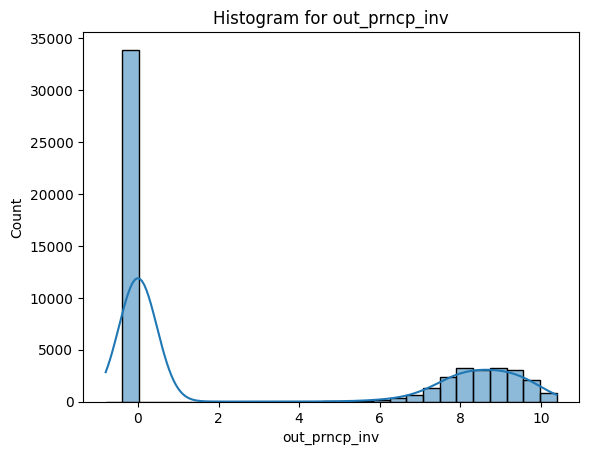

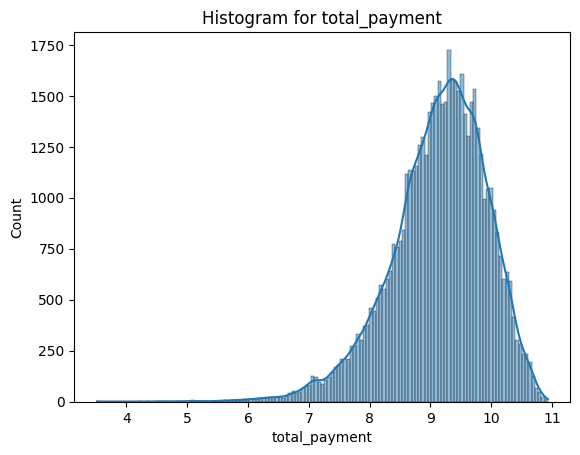

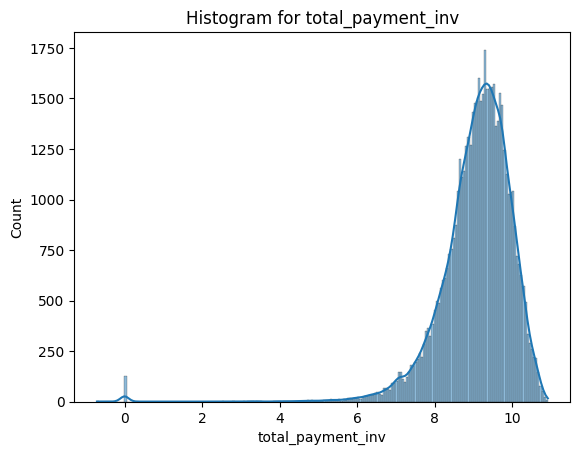

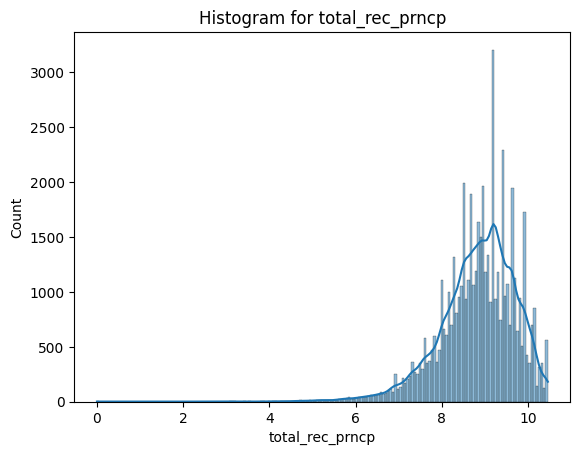

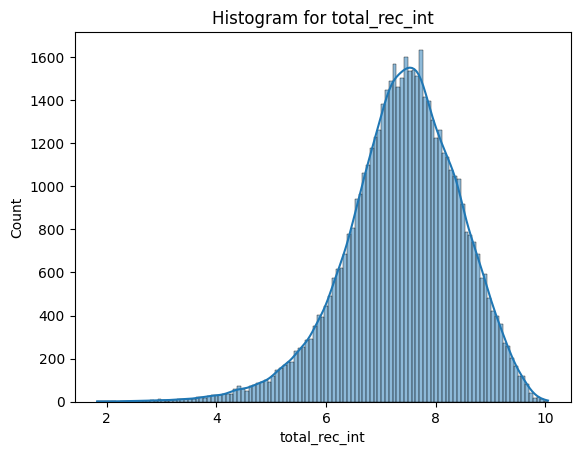

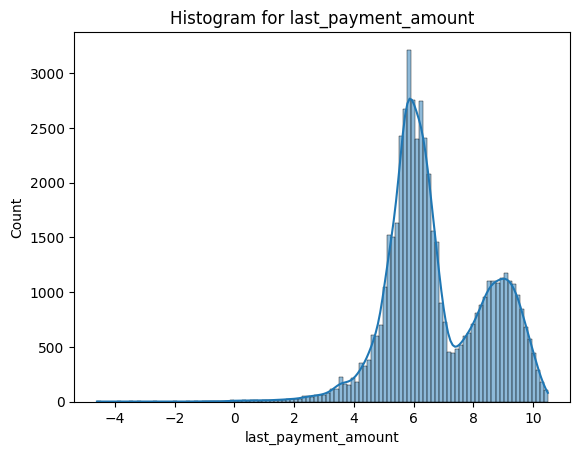

In [29]:
# Visualising data to see how log transformation has corrected the skew

plotter_1.kde_plot(loan_payments, skewed_cols)